In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
class Model(nn.Module):

  # Input layer contains 30x2 neurons (city coordinates) + 1 extra neuron (relaxation parameter)
  # Output layer contains 2 neurons (probability of feasable solution and expected distance)

  def __init__(self, in_features=30*2 + 1, h1=64, h2=64, h3=32, out_features=2):
    dropout = 0.4
    super().__init__() # instantiate nn.Module
    self.fc1 = nn.Linear(in_features, h1)
    self.bn1 = nn.BatchNorm1d(h1)
    self.dropout = nn.Dropout(dropout)
    self.fc2 = nn.Linear(h1,h2)
    self.bn2 = nn.BatchNorm1d(h2)
    self.dropout = nn.Dropout(dropout)
    self.fc3 = nn.Linear(h2,h3)
    self.bn3 = nn.BatchNorm1d(h3)
    self.dropout = nn.Dropout(dropout)
    self.out = nn.Linear(h3,out_features)

  def forward(self, x):
    x = torch.sigmoid(self.fc1(x))
    x = self.bn1(x)
    x = self.dropout(x)
    x = torch.sigmoid(self.fc2(x))
    x = self.bn2(x)
    x = self.dropout(x)
    x = torch.sigmoid(self.fc3(x))
    x = self.bn3(x)
    x = self.dropout(x)
    x = torch.sigmoid(self.out(x))
    return x

In [ ]:
model = Model() # instantiate model

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# upload training data
from google.colab import files

uploaded = files.upload()

Saving data.zip to data.zip


In [ ]:
import io
import zipfile

with zipfile.ZipFile(io.BytesIO(uploaded["data.zip"]), 'r') as zip_ref:
    zip_ref.extractall("training-data")

In [ ]:
# upload tsp instances
from google.colab import files

uploaded = files.upload()

Saving instances.zip to instances.zip


In [ ]:
with zipfile.ZipFile(io.BytesIO(uploaded["instances.zip"]), 'r') as zip_ref:
    zip_ref.extractall("instances")

In [ ]:
# clean tsp instance
def extract_coordinates(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    coord_section_index = lines.index("NODE_COORD_SECTION \n") + 1

    coordinates = [list(map(float, line.strip().split()[1:])) for line in lines[coord_section_index:]]

    return coordinates

In [ ]:
extract_coordinates("instances/instances/syn_tsp101.tsp")

[[6075.806908831769, 6465.459097028902],
 [1805.7093632409117, 7995.407087240192],
 [5445.28520578996, 4709.201310290762],
 [4958.446922875073, 4673.997127669553],
 [2533.036625960641, 3778.6898032738945],
 [5038.68622672101, 9796.680828742017],
 [6903.350369197077, 4121.00671838615],
 [7731.861596532035, 8600.158557245406],
 [6109.273940377136, 4844.822303021038],
 [5669.766963258698, 6325.045709491309],
 [4203.46698964822, 9567.637308171385],
 [9513.85872348577, 7458.025673101819],
 [8418.091434481072, 2834.239121002633],
 [3805.69633891788, 701.2654225968452],
 [3408.63315541289, 4874.748922237631],
 [3582.4275326243205, 6734.823796827744],
 [7579.383681027281, 8807.636128957125],
 [4465.230672654528, 4254.656775981333],
 [3426.0127567748486, 6253.612203657547],
 [6655.961312536285, 5903.31317428554],
 [6321.242697973241, 5975.006979370272],
 [6949.93866268607, 5136.079762560019],
 [3670.930539292524, 5273.267920504382],
 [8398.719454806347, 1526.1890320388284],
 [8242.731039512464,

In [ ]:
# normalize tsp instance
def normalize_coordinates(coordinates):
    max_value = max(max(map(abs, row)) for row in coordinates)

    if max_value == 0:
        return coordinates

    normalized_coordinates = [[coord / max_value for coord in row] for row in coordinates]

    return normalized_coordinates

In [ ]:
normalize_coordinates(extract_coordinates("instances/instances/syn_tsp101.tsp"))

[[0.6201903496749887, 0.6599642481012751],
 [0.18431848447519353, 0.8161342833363363],
 [0.555829601982571, 0.4806935525014411],
 [0.5061353951970876, 0.4771000718893214],
 [0.25856069726484143, 0.38571122907135813],
 [0.5143258532969909, 1.0],
 [0.70466216975689, 0.42065336111550394],
 [0.7892327750280373, 0.8778645244840282],
 [0.623606509916443, 0.49453711800092987],
 [0.5787436645505932, 0.6456314970407689],
 [0.4290705253268911, 0.976620293691854],
 [0.9711308237758967, 0.7612808668034863],
 [0.8592799522245976, 0.289306058914096],
 [0.38846793168483434, 0.07158194033834764],
 [0.3479375530345403, 0.4975918892790542],
 [0.3656776815790514, 0.6874597544373156],
 [0.7736685325901899, 0.8990428781875611],
 [0.4557901549220833, 0.4342957426456926],
 [0.34971158259269125, 0.6383398941925689],
 [0.6794098357281045, 0.6025829847356147],
 [0.6452433031632149, 0.6099011577309411],
 [0.7094176879067015, 0.5242673362891969],
 [0.37471166035363274, 0.5382708707865006],
 [0.8573025498764584, 0

In [ ]:
# testing combining data into a dataframe for a single instance
coordinates = extract_coordinates("instances/instances/syn_tsp101.tsp")
nc = normalize_coordinates(coordinates)
flat_coordinates = [coord for sublist in nc for coord in sublist]
idf = pd.DataFrame(data=[flat_coordinates])
ddf = pd.read_csv("training-data/data/syn_tsp101_instance1.csv")


ddf["E_avg"] /= max(max(map(abs, row)) for row in coordinates)

idf_repeated = pd.concat([idf] * len(ddf), ignore_index=True)
new_df = pd.concat([idf_repeated, ddf], axis=1)
new_df

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,Relaxation Parameter A,Probability P_f,E_avg,E_std,E_min
0,0.62019,0.659964,0.184318,0.816134,0.55583,0.480694,0.506135,0.4771,0.258561,0.385711,...,0.08417,0.511767,0.36908,0.853463,0.050779,4218.00,0.070312,6.837445,4649.904420,53518.151014
1,0.62019,0.659964,0.184318,0.816134,0.55583,0.480694,0.506135,0.4771,0.258561,0.385711,...,0.08417,0.511767,0.36908,0.853463,0.050779,4250.82,0.062500,6.815322,4467.012351,54283.345921
2,0.62019,0.659964,0.184318,0.816134,0.55583,0.480694,0.506135,0.4771,0.258561,0.385711,...,0.08417,0.511767,0.36908,0.853463,0.050779,4283.64,0.054688,6.918838,4606.098256,56801.810406
3,0.62019,0.659964,0.184318,0.816134,0.55583,0.480694,0.506135,0.4771,0.258561,0.385711,...,0.08417,0.511767,0.36908,0.853463,0.050779,4316.46,0.046875,6.936339,4428.735985,57256.237944
4,0.62019,0.659964,0.184318,0.816134,0.55583,0.480694,0.506135,0.4771,0.258561,0.385711,...,0.08417,0.511767,0.36908,0.853463,0.050779,4349.28,0.054688,6.930048,4117.578820,57903.136557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.62019,0.659964,0.184318,0.816134,0.55583,0.480694,0.506135,0.4771,0.258561,0.385711,...,0.08417,0.511767,0.36908,0.853463,0.050779,7335.90,0.929688,9.148504,7083.258787,74993.455798
96,0.62019,0.659964,0.184318,0.816134,0.55583,0.480694,0.506135,0.4771,0.258561,0.385711,...,0.08417,0.511767,0.36908,0.853463,0.050779,7368.72,0.945312,9.235136,7504.306268,75748.035340
97,0.62019,0.659964,0.184318,0.816134,0.55583,0.480694,0.506135,0.4771,0.258561,0.385711,...,0.08417,0.511767,0.36908,0.853463,0.050779,7401.54,0.953125,9.253635,7352.265232,69132.672314
98,0.62019,0.659964,0.184318,0.816134,0.55583,0.480694,0.506135,0.4771,0.258561,0.385711,...,0.08417,0.511767,0.36908,0.853463,0.050779,7434.36,0.921875,9.220522,7237.830537,70503.720228


In [ ]:
# debugging
new_df.to_csv('df.csv')
files.download('df.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# combining all training data

import os

# training data
training_path = "training-data/data"
training_file_list = sorted(os.listdir(training_path))
csv_files = [file for file in training_file_list if file.endswith('.csv')]

# instances
instance_path = "instances/instances"
instance_file_list = sorted(os.listdir(instance_path))
instance_files = [file for file in instance_file_list if file.endswith('.tsp')]

combined_df = pd.DataFrame()

i = 0
for csv_file in csv_files:
    file_path = os.path.join(training_path, csv_file)
    data_df = pd.read_csv(file_path)

    coordinates = extract_coordinates(os.path.join(instance_path,instance_files[i]))
    normalized_coords = normalize_coordinates(coordinates)
    flat_coordinates = [coord for sublist in normalized_coords for coord in sublist]
    instance_df = pd.DataFrame(data=[flat_coordinates])

    instance_df_repeated = pd.concat([instance_df] * len(data_df), ignore_index=True)
    new_df = pd.concat([instance_df_repeated, data_df], axis=1)

    new_df["E_avg"] /= max(max(map(abs, row)) for row in coordinates) # normalizing the output energy

    combined_df = pd.concat([combined_df, new_df], ignore_index=True)
    i = i + 1

# remove E_std and E_min
combined_df = combined_df.iloc[:, :-2]
combined_df["E_avg"] = combined_df["E_avg"] / combined_df["E_avg"].max()
rmax = combined_df["Relaxation Parameter A"].max()
combined_df["Relaxation Parameter A"] = 3 * combined_df["Relaxation Parameter A"] / rmax

In [ ]:
combined_df

,0,1,2,3,4,5,6,7,8,9,...,53,54,55,56,57,58,59,Relaxation Parameter A,Probability P_f,E_avg
0,0.620190,0.659964,0.184318,0.816134,0.555830,0.480694,0.506135,0.477100,0.258561,0.385711,...,0.444869,0.861736,0.08417,0.511767,0.369080,0.853463,0.050779,1.271759,0.070312,0.534859
1,0.620190,0.659964,0.184318,0.816134,0.555830,0.480694,0.506135,0.477100,0.258561,0.385711,...,0.444869,0.861736,0.08417,0.511767,0.369080,0.853463,0.050779,1.281654,0.062500,0.533128
2,0.620190,0.659964,0.184318,0.816134,0.555830,0.480694,0.506135,0.477100,0.258561,0.385711,...,0.444869,0.861736,0.08417,0.511767,0.369080,0.853463,0.050779,1.291550,0.054688,0.541226
3,0.620190,0.659964,0.184318,0.816134,0.555830,0.480694,0.506135,0.477100,0.258561,0.385711,...,0.444869,0.861736,0.08417,0.511767,0.369080,0.853463,0.050779,1.301445,0.046875,0.542595
4,0.620190,0.659964,0.184318,0.816134,0.555830,0.480694,0.506135,0.477100,0.258561,0.385711,...,0.444869,0.861736,0.08417,0.511767,0.369080,0.853463,0.050779,1.311341,0.054688,0.542102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8495,0.551254,0.645869,0.763434,0.985736,0.918051,0.946367,1.000000,0.346324,0.443404,0.237354,...,0.537507,0.094035,0.44053,0.982542,0.944231,0.345318,0.902583,0.146744,0.984375,0.927583
8496,0.551254,0.645869,0.763434,0.985736,0.918051,0.946367,1.000000,0.346324,0.443404,0.237354,...,0.537507,0.094035,0.44053,0.982542,0.944231,0.345318,0.902583,0.147546,1.000000,0.934811
8497,0.551254,0.645869,0.763434,0.985736,0.918051,0.946367,1.000000,0.346324,0.443404,0.237354,...,0.537507,0.094035,0.44053,0.982542,0.944231,0.345318,0.902583,0.148348,1.000000,0.919593
8498,0.551254,0.645869,0.763434,0.985736,0.918051,0.946367,1.000000,0.346324,0.443404,0.237354,...,0.537507,0.094035,0.44053,0.982542,0.944231,0.345318,0.902583,0.149150,1.000000,0.936231


In [ ]:
X = combined_df.iloc[:, :-2]
y = combined_df.iloc[:, 61:]

In [ ]:
X_values = X.values
y_values = y.values

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train , x_test, Y_train, y_test = train_test_split(X_values, y_values, test_size=0.1, random_state=100, shuffle=False)
x_train , x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=100, shuffle=False)

In [ ]:
y_test_array = y_test
y_train_array = y_train

In [ ]:
x_train = torch.FloatTensor(x_train)
x_test = torch.FloatTensor(x_test)
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)
x_val = torch.FloatTensor(x_val)
y_val = torch.FloatTensor(y_val)

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
# Create a TensorDataset from your input and target tensors
dataset = TensorDataset(x_train, y_train)

# Create a DataLoader with the specified batch size
loader = DataLoader(dataset, batch_size=32, shuffle=True)

model = Model()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
# training!

min_loss = float('inf')
patience = 5000
counter = 0

epochs = 20000
losses = []
losses_val = []

for i in range(epochs):
  y_prediction = model.forward(x_train)

  # measure loss
  loss = criterion(y_prediction, y_train)

  y_val_pred = model.forward(x_val)
  loss_val = criterion(y_val_pred, y_val)

  losses.append(loss.detach().numpy())
  losses_val.append(loss_val.detach().numpy())

  if loss_val < min_loss:
      min_loss = loss_val
      counter = 0
  else:
      counter += 1
      if counter >= patience:
          print(f"Early stopping at epoch {i}")
          epochs = i+1
          break


  # print every 5 iterations
  if i % 10 == 0:
    print(f"Epoch: {i}, Loss: {loss}")
    print(f"Epoch: {i}, Loss_val: {loss_val}")


  # back propagation
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

Epoch: 0, Loss: 0.11542835831642151
Epoch: 0, Loss_val: 0.11482023447751999
Epoch: 10, Loss: 0.05635855719447136
Epoch: 10, Loss_val: 0.09930054098367691
Epoch: 20, Loss: 0.03867724537849426
Epoch: 20, Loss_val: 0.09654027223587036
Epoch: 30, Loss: 0.030777592211961746
Epoch: 30, Loss_val: 0.10461956262588501
Epoch: 40, Loss: 0.026758188381791115
Epoch: 40, Loss_val: 0.1075977012515068
Epoch: 50, Loss: 0.02278849110007286
Epoch: 50, Loss_val: 0.11693646758794785
Epoch: 60, Loss: 0.020755959674715996
Epoch: 60, Loss_val: 0.11779475957155228
Epoch: 70, Loss: 0.019836755469441414
Epoch: 70, Loss_val: 0.12100222706794739
Epoch: 80, Loss: 0.017739085480570793
Epoch: 80, Loss_val: 0.12082622945308685
Epoch: 90, Loss: 0.017523502930998802
Epoch: 90, Loss_val: 0.12097018212080002
Epoch: 100, Loss: 0.016573861241340637
Epoch: 100, Loss_val: 0.12415944039821625
Epoch: 110, Loss: 0.015425467863678932
Epoch: 110, Loss_val: 0.12232284992933273
Epoch: 120, Loss: 0.015194911509752274
Epoch: 120, Loss

Text(0.5, 0, 'Iteration')

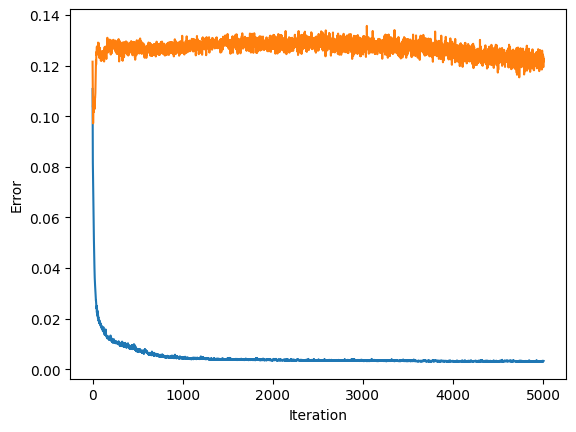

In [ ]:
plt.plot(range(epochs), losses)
plt.plot(range(epochs), losses_val)
plt.ylabel("Error")
plt.xlabel("Iteration")

In [ ]:
predictions = []

with torch.no_grad():
    for i, data in enumerate(x_test):
        y_val = model.forward(data)
        predictions.append(y_val.numpy())

ValueError: expected 2D or 3D input (got 1D input)

In [ ]:
print(y_test[:, 0])

tensor([0.7812, 0.7891, 0.8438, 0.8359, 0.8516, 0.7812, 0.8438, 0.8828, 0.8906,
        0.8281, 0.8203, 0.8828, 0.9141, 0.8906, 0.8828, 0.9219, 0.8984, 0.8984,
        0.8906, 0.8516, 0.9141, 0.8828, 0.9375, 0.9062, 0.9375, 0.9688, 0.9531,
        0.8906, 0.9531, 0.9609, 0.9688, 0.9688, 0.9688, 0.9609, 0.9609, 0.9453,
        0.9609, 1.0000, 0.9609, 0.9766, 0.9844, 0.9922, 0.9609, 0.9844, 0.9844,
        1.0000, 0.9688, 1.0000, 0.9766, 0.9922, 0.0312, 0.0156, 0.0781, 0.0469,
        0.0156, 0.0938, 0.0859, 0.1016, 0.1016, 0.0938, 0.1562, 0.1250, 0.1328,
        0.1094, 0.1875, 0.2188, 0.2500, 0.2188, 0.2969, 0.2734, 0.2656, 0.3125,
        0.2969, 0.3828, 0.3359, 0.3750, 0.3594, 0.3906, 0.4062, 0.4297, 0.5000,
        0.4062, 0.4922, 0.5469, 0.5078, 0.5703, 0.5391, 0.5391, 0.6562, 0.6016,
        0.5234, 0.5938, 0.6172, 0.7031, 0.6562, 0.6953, 0.6719, 0.7109, 0.6719,
        0.7969, 0.7031, 0.7891, 0.7188, 0.7969, 0.7656, 0.8203, 0.7656, 0.7656,
        0.8828, 0.8750, 0.7891, 0.8828, 

In [ ]:
import numpy

pred_pf = [inner_list[0] for inner_list in predictions]
pred_eavg = [inner_list[1] for inner_list in predictions]

mae_pf = torch.mean(torch.abs(torch.FloatTensor(pred_pf) - y_test[:, 0]))
mae_eavg = torch.mean(torch.abs(torch.FloatTensor(pred_eavg) - y_test[:, 1]))

print(f"P_f mean absolute error: {mae_pf}, E_avg mean absolute error: {mae_eavg}")

RuntimeError: The size of tensor a (0) must match the size of tensor b (850) at non-singleton dimension 0

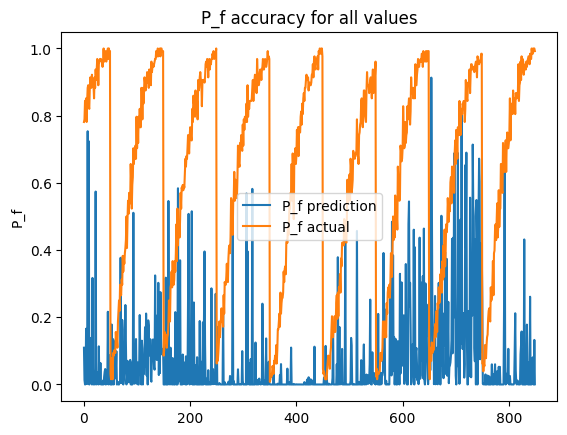

In [ ]:
x = [i for i in range(len(predictions))]
plt.plot(x, pred_pf, label='P_f prediction')
plt.plot(x, y_test[:, 0], label='P_f actual')
plt.ylabel('P_f')
plt.title('P_f accuracy for all values')
plt.legend()
plt.show()

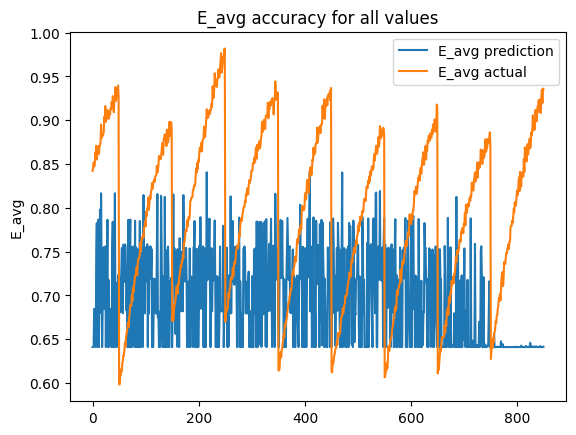

In [ ]:
x = [i for i in range(len(predictions))]
plt.plot(x, pred_eavg, label='E_avg prediction')
plt.plot(x, y_test[:, 1], label='E_avg actual')
plt.ylabel('E_avg')
plt.title('E_avg accuracy for all values')
plt.legend()
plt.show()

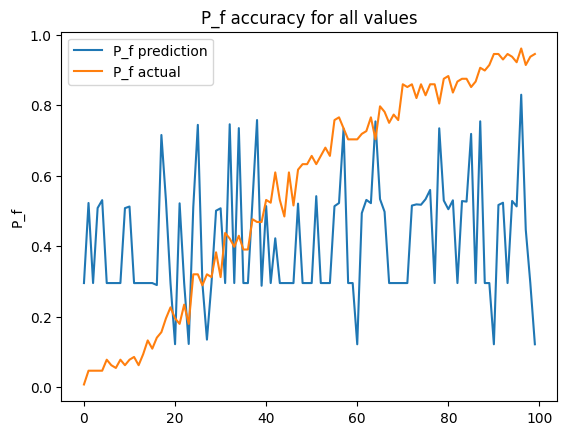

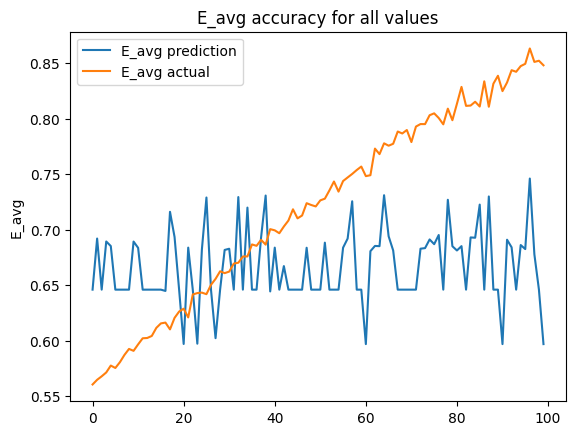

In [ ]:
x = [i for i in range(len(predictions))][:100]
plt.plot(x, pred_pf[:100], label='P_f prediction')
plt.plot(x, y_test[:100, 0], label='P_f actual')
plt.ylabel('P_f')
plt.title('P_f accuracy for all values')
plt.legend()
plt.show()

x = [i for i in range(len(predictions))][:100]
plt.plot(x, pred_eavg[:100], label='E_avg prediction')
plt.plot(x, y_test[:100, 1], label='E_avg actual')
plt.ylabel('E_avg')
plt.title('E_avg accuracy for all values')
plt.legend()
plt.show()